Faster R-CNN을 활용하여 지하철이미지에서 승객의 머리를 detecting하는 코드입니다.  
pytorch에서 제공해주는 fasterrcnn_resnet50_fpn_v2 모델을 사용했고 이미 학습된 파라메터를 가져온 후 저희의 데이터로 fine tuning 하였습니다.  
총 40에포크를 학습하여 val_loss가 가장 작아질때 의 모델을 최종모델로 사용했고 학습과정에서 모멘텀을 이용한 SGD optimizer를 사용 하였습니다.  
그리고 StepLR을 사용하여 learning rate를 조정하였는데, 0.005에서 시작하여 10에포크마다 절반씩 줄어들도록 하였습니다.

In [1]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time
import torch
import copy
import seaborn as sns
import pandas as pd

데이터 파일 경로

In [2]:
base_dir = "./"
train_images_path = os.path.join(base_dir,"images/train") 
train_annotations_path = os.path.join(base_dir,"labels/Faster R-CNN/train")
val_images_path = os.path.join(base_dir,"images/val")
val_annotations_path = os.path.join(base_dir,"labels/Faster R-CNN/val")
test_images_path = os.path.join(base_dir,"images/test")
test_annotations_path = os.path.join(base_dir,"labels/Faster R-CNN/test")

Batch size, Epochs, device 설정

In [3]:
TRAIN_BATCH = 2 #out of memory error로 인함
VAL_BATCH = 2
TEST_BATCH = 2
EPOCHS = 2
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

학습, 예측을 위해 필요한 함수들

In [4]:
#txt형식의 annotations파일을 받아서 모델에서 요구하는 dictionary형태로 바꾸어줌
def generate_target(file):
    with open(file) as f:
        data_str = f.read()
        
        boxes = []
        labels = []
        
        for line in data_str.splitlines():
            elements = list(map(int, line.split()))

            labels.append(1) #label을 1로
            boxes.append(elements[1:])

        # labels와 boxes를 텐서로 변환
        labels = torch.as_tensor(labels, dtype=torch.int64)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
    
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target
        
#이미지 위에 box를 그려서 출력
def plot_image_from_output(img, annotation):

    img = img.cpu().permute(1,2,0)

    fig,ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(rect)

    plt.show()

#배치를 만들 때 사용
def collate_fn(batch):
    return tuple(zip(*batch))
    

#모델을 정의
def get_model_instance_segmentation(num_classes):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

#예측을 반환
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold:
                 idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

DataSet을 model이 요구하는 형태로 가져오기위한 클래스

In [5]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # transform module과 img path 경로를 정의
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'txt'
        img_path = os.path.join(self.path, file_image)

        if 'val' in self.path:
            label_path = os.path.join(val_annotations_path, file_label)
        elif 'test' in self.path:
            label_path = os.path.join(test_annotaions_path, file_label)
        else:
            label_path = os.path.join(train_annotations_path, file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

transform 정의

In [6]:
data_transform = transforms.Compose([  # transforms.Compose : list 내의 작업을 연달아 할 수 있게 호출하는 클래스
        transforms.ToTensor() # ToTensor : numpy 이미지에서 torch 이미지로 변경
])

dataset 가져오고 DataLoader정의

In [7]:
train_dataset = MaskDataset(data_transform, train_images_path)
val_dataset = MaskDataset(data_transform, val_images_path)

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BATCH, collate_fn=collate_fn)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=VAL_BATCH, collate_fn=collate_fn)

모델 생성

In [8]:
model = get_model_instance_segmentation(2) #fine tuning할 모델
model.to(device)

c:\Users\Choe\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Choe\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

Optimizer, Scheduler 생성

In [9]:
params = [p for p in model.parameters() if p.requires_grad] #requrires_grad가 True인 파라메터만 학습 할 것

# Optimizer 설정
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# 학습률 스케줄러 설정 (10 에포크마다 학습률을 0.5배로 감소, 총 50 에포크 학습)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [10]:
train_log_dict = {
    'train_loss' : [], 
    'val_loss' : [],
    'learning_rate' : []
}

print('----------------------train start--------------------------')
min_val_loss = float('inf') #무한대로 초기화

for epoch in range(EPOCHS):
    start = time.time()
    
    train_loss = 0
    val_loss = 0
    
    model.train()
    for imgs, annotations in train_data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        #losses = sum(loss for loss in loss_dict.values())
        #loss_classifier를 사용하지 않음
        #losses = loss_dict["loss_box_reg"] + loss_dict["loss_objectness"] + loss_dict["loss_rpn_box_reg"]
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        train_loss += losses.item()

    scheduler.step()#스케줄러로 lr 갱신
    train_log_dict['learning_rate'].append(scheduler.get_last_lr()[0]) #현재 lr을 기록

    #val loss를 구한다
    #model.eval()모드로 하면 반환값이 preds이기 때문에 위의 loss를 구할 수 없다
    with torch.no_grad():  #gradient계산을 멈춤
        for imgs, annotations in val_data_loader:
            imgs = list(img.to(device) for img in imgs)
            annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
            loss_dict = model(imgs, annotations)  # Get the loss dictionary
            losses = sum(loss for loss in loss_dict.values())  # Sum the losses
            #losses = loss_dict["loss_box_reg"] + loss_dict["loss_objectness"] + loss_dict["loss_rpn_box_reg"]

            val_loss += losses.item()  # Accumulate the validation loss

    #최고의 모델 저장        
    if(val_loss < min_val_loss): #최고의 모델 저장
         best_model_wts = copy.deepcopy(model.state_dict())
         min_val_loss = val_loss

    train_log_dict['train_loss'].append(train_loss / len(train_data_loader))
    train_log_dict['val_loss'].append(val_loss / len(val_data_loader))
    
    print(f'Epoch : {epoch+1}, Train Loss : {train_loss/len(train_data_loader)}, Val Loss : {val_loss/len(val_data_loader)}, Time : {time.time() - start:.2f} sec')
    
    torch.save(model, f'Faster_R-CNN_final_{epoch+1}.pt') #모델전체를 매 에포크마다 저장

model.load_state_dict(best_model_wts) #최고의 모델을 load


----------------------train start--------------------------
Epoch : 1, Train Loss : 0.9604193212301471, Val Loss : 1.3314802588820458, Time : 1359.04 sec
Epoch : 2, Train Loss : 0.9129902167203836, Val Loss : 1.307138464987278, Time : 1359.94 sec


<All keys matched successfully>

학습그래프 그리기

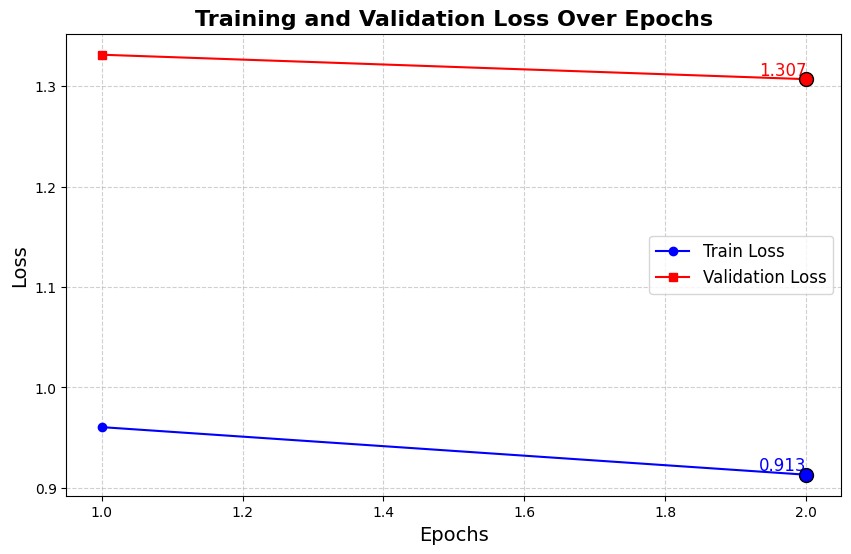

In [11]:
epochs = range(1, len(train_log_dict['train_loss']) + 1)

# 최솟값 구하기
min_train_loss = min(train_log_dict['train_loss'])
min_train_epoch = train_log_dict['train_loss'].index(min_train_loss) + 1

min_val_loss = min(train_log_dict['val_loss'])
min_val_epoch = train_log_dict['val_loss'].index(min_val_loss) + 1

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_log_dict['train_loss'], 'o-', label='Train Loss', color='blue')
plt.plot(epochs, train_log_dict['val_loss'], 's-', label='Validation Loss', color='red')

# 최솟값 표시
plt.scatter(min_train_epoch, min_train_loss, color='blue', s=100, edgecolor='black', zorder=5)
plt.text(min_train_epoch, min_train_loss, f'{min_train_loss:.3f}', 
         fontsize=12, color='blue', ha='right', va='bottom')

plt.scatter(min_val_epoch, min_val_loss, color='red', s=100, edgecolor='black', zorder=5)
plt.text(min_val_epoch, min_val_loss, f'{min_val_loss:.3f}', 
         fontsize=12, color='red', ha='right', va='bottom')

# 제목 및 레이블 추가
plt.title('Training and Validation Loss Over Epochs', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# 그리드 및 범례 추가
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# 그래프 표시
plt.show()

실제 bounding box 예측을 확인

In [ ]:
untrained_model = get_model_instance_segmentation(2) #비교를 위해 학습시키지 않은 모델 생성
untrained_model.to(device)

_idx = 0
threshold = 0.50 #높일수록 둔감해짐

with torch.no_grad():
    # 테스트셋 배치사이즈= 2
    for i, (imgs, annotations) in enumerate(val_data_loader):
        if(i== 5):
            imgs = list(img.to(device) for img in imgs)
            untrained_pred = make_prediction(untrained_model, imgs, threshold)
            pred = make_prediction(model, imgs, threshold)
            break
    
print("target image")
plot_image_from_output(imgs[_idx], annotations[_idx])

print("not trained model output")
plot_image_from_output(imgs[_idx], {
    'labels': untrained_pred[_idx]['labels'].cpu(),
    'boxes': untrained_pred[_idx]['boxes'].cpu(),
    'scores': untrained_pred[_idx]['scores'].cpu()
})

print("trained model output")
plot_image_from_output(imgs[_idx], {
    'labels': pred[_idx]['labels'].cpu(),
    'boxes': pred[_idx]['boxes'].cpu(),
    'scores': pred[_idx]['scores'].cpu()
})

부산역 데이터에도 잘 적용 되는지 확인

In [ ]:
img_path = r'C:\Users\Choe\my_study\20240627 혼잡도테스트 이미지\car2_image\car2_cam2_24_13.jpg'  # 예측할 이미지의 경로
img = Image.open(img_path)
img_tensor = data_transform(img)
input = [img_tensor]

with torch.no_grad():
    input[0] = input[0].to(device)
    pred = make_prediction(model, input, 0.5)


# Plot the image with prediction annotations
plot_image_from_output(input[0], {
    'labels': pred[0]['labels'].cpu(),
    'boxes': pred[0]['boxes'].cpu(),
    'scores': pred[0]['scores'].cpu()
})

결과 분석을 위한 함수들

In [14]:
#threshold에 따라 recall, precision, f1-score가 달라지는 양상을 그래프로 그리고 f1-score가 최고일때의 threshold를 반환한다.
def draw_f1_plot(model, images_path, annotations_path):
    thresholds = np.linspace(0.0, 1.0, 101)
    precision_avg = np.zeros_like(thresholds)  # 길이가 thresholds와 같은 0 배열
    recall_avg = np.zeros_like(thresholds)     # 길이가 thresholds와 같은 0 배열
    f1_avg = np.zeros_like(thresholds)         # 길이가 thresholds와 같은 0 배열
 
    files = os.listdir(images_path) #이미지 파일 리스트

    for i, file in enumerate(files):
        try:
            with open(os.path.join(annotations_path, file[:-3] + "txt"), 'r') as annotation:
                lines = annotation.readlines()
                true_boxes = []
                for line in lines:
                    true_boxes.append(list(map(int,line.split()[1:])))

            #detection
            img = Image.open(os.path.join(images_path, file))
            img_tensor = data_transform(img)
            input = [img_tensor]
            with torch.no_grad():
                input[0] = input[0].to(device)
                model.eval()
                preds = model(input)

            for j,threshold in enumerate(thresholds):
                pred_boxes = []
                for idx, score in enumerate(preds[0]['scores']) :
                    if score > threshold:
                        pred_boxes.append(preds[0]['boxes'][idx].tolist())
                    
                precision, recall, f1_score = calculate_metrics(true_boxes = true_boxes, pred_boxes = pred_boxes)

                precision_avg[j] += precision
                recall_avg[j] += recall
                f1_avg[j] += f1_score
            print(i*100/len(files),"%진행",end = '\r')
            # if(i==10):
            #     break
        except Exception as e:
            print(f"{file}을 여는데 실패하였음")
            print(e)
    
    for j,threshold in enumerate(thresholds):
        precision_avg[j] /= len(files)
        recall_avg[j] /= len(files)
        f1_avg[j] /= len(files)

    # 최대값과 해당 threshold 직접 계산
    precision_max_idx = np.argmax(precision_avg)
    recall_max_idx = np.argmax(recall_avg)
    f1_max_idx = np.argmax(f1_avg)

    precision_max_threshold = thresholds[precision_max_idx]
    precision_max_value = precision_avg[precision_max_idx]

    recall_max_threshold = thresholds[recall_max_idx]
    recall_max_value = recall_avg[recall_max_idx]

    f1_max_threshold = thresholds[f1_max_idx]
    f1_max_value = f1_avg[f1_max_idx]

    # 그래프 그리기
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 8))

    sns.lineplot(x=thresholds, y=precision_avg, label='Precision', marker='o', color='blue')
    sns.lineplot(x=thresholds, y=recall_avg, label='Recall', marker='o', color='green')
    sns.lineplot(x=thresholds, y=f1_avg, label='F1-Score', marker='o', color='red')

    # 최대값과 해당 threshold를 그래프에 표시
    plt.scatter(precision_max_threshold, precision_max_value, color='blue', s=100, edgecolor='black', zorder=5)
    plt.scatter(recall_max_threshold, recall_max_value, color='green', s=100, edgecolor='black', zorder=5)
    plt.scatter(f1_max_threshold, f1_max_value, color='red', s=100, edgecolor='black', zorder=5)

    # 최대값 레이블 추가
    plt.text(precision_max_threshold, precision_max_value, 
            f'Threshold: {precision_max_threshold:.2f}\nPrecision: {precision_max_value:.2f}', 
            color='blue', fontsize=12, ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.7))
    plt.text(recall_max_threshold, recall_max_value, 
            f'Threshold: {recall_max_threshold:.2f}\nRecall: {recall_max_value:.2f}', 
            color='green', fontsize=12, ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.7))
    plt.text(f1_max_threshold, f1_max_value, 
            f'Threshold: {f1_max_threshold:.2f}\nF1-Score: {f1_max_value:.2f}', 
            color='red', fontsize=12, ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.7))

    # 그래프에 스타일 추가
    plt.xlabel('Thresholds', fontsize=14)
    plt.ylabel('Scores', fontsize=14)
    plt.title('Precision, Recall, and F1-Score vs Thresholds', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()

    plt.show()

    return f1_max_threshold

#data frame을 반환하고 output_path에 csv파일을 저장해준다
#model.to(deviece)는 미리하고 전달 해 주어야한다.
def generate_result_df(images_path, annotations_path, output_path, model, threshold):
    # 결과 데이터프레임 생성
    result_df = pd.DataFrame({
        "File1": [],
        "Detected Heads1": [],
        "Bounded Heads1": [],
        "Detection Rate1": [],
        "File2": [],
        "Detected Heads2": [],
        "Bounded Heads2": [],
        "Detection Rate2": [],
        "Sum(Detected Heads)": [],
        "Sum(Bounded Heads)": [],
        "Passengers": [],
        "Detection Rate": [],
        "Bound Rate": [],
        "Precision" : [],
        "Recall" : [],
        "F1-score" : [],
    })

    # 문자열 타입 설정
    string_columns = ["File1", "File2"]
    result_df[string_columns] = result_df[string_columns].astype(str)

    # 정수형 타입 설정
    int_columns = ["Detected Heads1", "Bounded Heads1", "Detected Heads2", "Bounded Heads2", 
                "Sum(Detected Heads)", "Sum(Bounded Heads)", "Passengers"]
    result_df[int_columns] = result_df[int_columns].astype(int)

    # 실수형 타입 설정
    float_columns = ["Detection Rate1", "Detection Rate2", "Detection Rate", "Bound Rate"]
    result_df[float_columns] = result_df[float_columns].astype(float)

    files = os.listdir(images_path) #이미지 파일 리스트
    files1 = [file for file in files if 'cam1' in file] #cam1파일만 필터링

    for idx, file1 in enumerate(files1):
        result_df.loc[idx, "Passengers"] = int(file1.split("_")[2])
        for cam in [1, 2]:
            file = file1 if cam == 1 else file1.replace('cam1', 'cam2')
            result_df.loc[idx, f"File{cam}"] = file[:-4]
                
            try:
                with open(os.path.join(annotations_path, file[:-3] + "txt"), 'r') as annotation:
                    lines = annotation.readlines()
                    result_df.loc[idx, f"Bounded Heads{cam}"] = len(lines)
                    
                    true_boxes = []
                    for line in lines:
                        true_boxes.append(list(map(int,line.split()[1:])))

                #detection
                img = Image.open(os.path.join(images_path, file))
                img_tensor = data_transform(img)
                input = [img_tensor]
                with torch.no_grad():
                    input[0] = input[0].to(device)
                    pred = make_prediction(model, input, threshold)
            
                result_df.loc[idx, f"Detected Heads{cam}"] = int(pred[0]['boxes'].size()[0])

                pred_boxes = pred[0]['boxes'].tolist()
                precision, recall, F1_score = calculate_metrics(pred_boxes = pred_boxes, true_boxes = true_boxes, iou_threshold = 0.1)
                result_df.loc[idx, "Precision"] = precision
                result_df.loc[idx, "Recall"] = recall
                result_df.loc[idx, "F1-score"] = F1_score

            except Exception as e:
                print(f"{file}을 여는데 실패하였음")
                print(e)
    
    for cam in [1, 2]:
        result_df[f"Detection Rate{cam}"] = result_df[f"Detected Heads{cam}"] / result_df[f"Bounded Heads{cam}"]

    result_df['Sum(Detected Heads)'] = result_df['Detected Heads1'] + result_df['Detected Heads2']
    result_df['Sum(Bounded Heads)'] = result_df['Bounded Heads1'] + result_df['Bounded Heads2']

    #passeneger가 0명일때 문제 발생
    result_df["Detection Rate"] = result_df['Sum(Detected Heads)'] / result_df["Passengers"]
    result_df["Bound Rate"] = result_df['Sum(Bounded Heads)'] / result_df["Passengers"]
    
    result_df.to_csv(output_path, index = False)
    return result_df

######################################################################필요한 함수들########################################################################
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold:
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]
    return preds

def calculate_iou(box1, box2):
    x_min1, y_min1, x_max1, y_max1 = box1
    x_min2, y_min2, x_max2, y_max2 = box2

    inter_x_min = max(x_min1, x_min2)
    inter_y_min = max(y_min1, y_min2)
    inter_x_max = min(x_max1, x_max2)
    inter_y_max = min(y_max1, y_max2)

    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)
    box1_area = (x_max1 - x_min1) * (y_max1 - y_min1)
    box2_area = (x_max2 - x_min2) * (y_max2 - y_min2)

    iou = inter_area / float(box1_area + box2_area - inter_area)
    return iou

def calculate_metrics(pred_boxes, true_boxes, iou_threshold=0.5):
    iou_pairs = []

    for pred_idx, pred_box in enumerate(pred_boxes):
        for true_idx, true_box in enumerate(true_boxes):
            iou = calculate_iou(pred_box, true_box)
            if iou >= iou_threshold:
                iou_pairs.append((iou, pred_idx, true_idx))

    # IoU 기준으로 내림차순 정렬
    iou_pairs.sort(reverse=True, key=lambda x: x[0])

    matched_true = set()
    matched_pred = set()
    TP = 0

    for _, pred_idx, true_idx in iou_pairs:
        if pred_idx not in matched_pred and true_idx not in matched_true:
            matched_pred.add(pred_idx)
            matched_true.add(true_idx)
            TP += 1

    precision = TP / len(pred_boxes) if len(pred_boxes) > 0 else 0
    recall = TP / len(true_boxes) if len(true_boxes) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, f1_score
    

최적의 threshold를 찾아보자

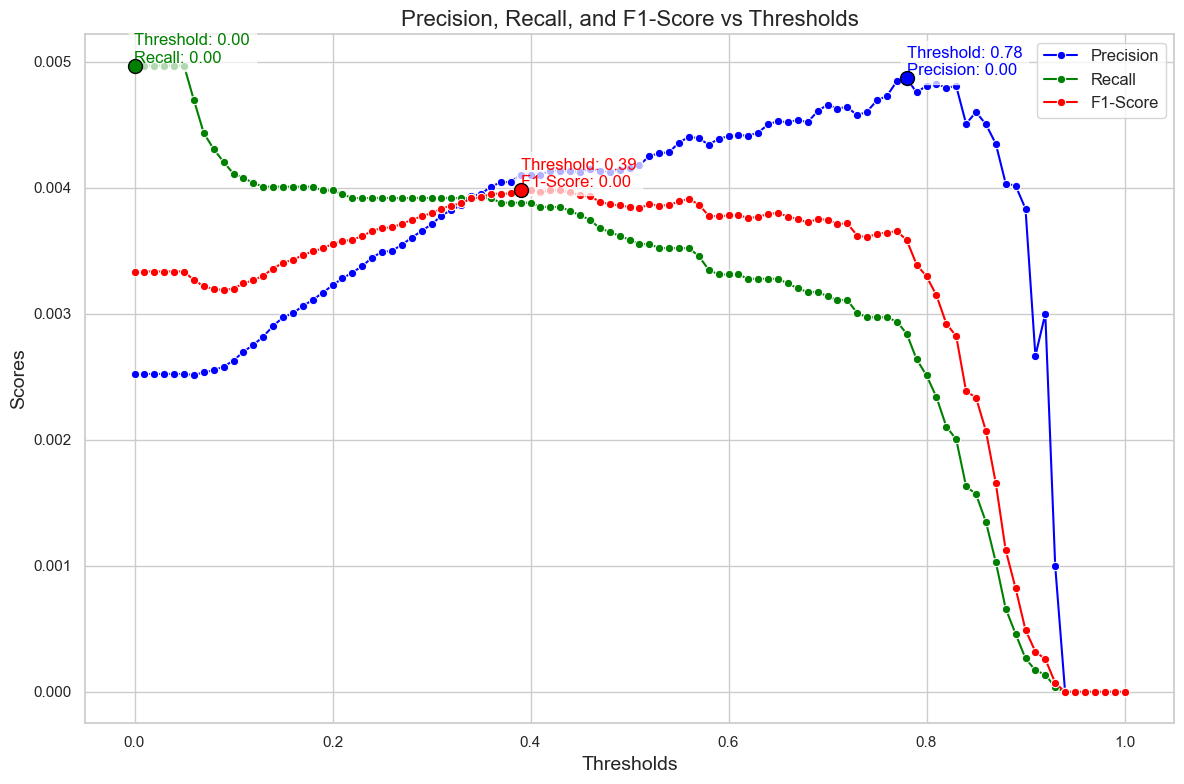

In [15]:
best_threshold = draw_f1_plot(model, val_images_path, val_annotations_path)

결과파일 생성

In [16]:
generate_result_df(test_images_path, test_annotations_path, "Faster_R-CNN_final.csv", model, best_threshold)

,File1,Detected Heads1,Bounded Heads1,Detection Rate1,File2,Detected Heads2,Bounded Heads2,Detection Rate2,Sum(Detected Heads),Sum(Bounded Heads),Passengers,Detection Rate,Bound Rate,Precision,Recall,F1-score
0,car1_cam1_104_105,30.0,31.0,0.967742,car1_cam2_104_105,35.0,38.0,0.921053,65.0,69.0,104.0,0.625000,0.663462,0.942857,0.868421,0.904110
1,car1_cam1_104_107,29.0,31.0,0.935484,car1_cam2_104_107,35.0,38.0,0.921053,64.0,69.0,104.0,0.615385,0.663462,0.942857,0.868421,0.904110
2,car1_cam1_104_109,28.0,29.0,0.965517,car1_cam2_104_109,32.0,37.0,0.864865,60.0,66.0,104.0,0.576923,0.634615,0.968750,0.837838,0.898551
3,car1_cam1_104_110,28.0,30.0,0.933333,car1_cam2_104_110,33.0,38.0,0.868421,61.0,68.0,104.0,0.586538,0.653846,1.000000,0.868421,0.929577
4,car1_cam1_104_111,29.0,31.0,0.935484,car1_cam2_104_111,35.0,38.0,0.921053,64.0,69.0,104.0,0.615385,0.663462,0.942857,0.868421,0.904110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,car2_cam1_91_44,33.0,33.0,1.000000,car2_cam2_91_44,31.0,34.0,0.911765,64.0,67.0,91.0,0.703297,0.736264,1.000000,0.911765,0.953846
496,car2_cam1_91_5,34.0,37.0,0.918919,car2_cam2_91_5,36.0,33.0,1.090909,70.0,70.0,91.0,0.769231,0.769231,0.888889,0.969697,0.927536
497,car2_cam1_91_61,33.0,37.0,0.891892,car2_cam2_91_61,31.0,33.0,0.939394,64.0,70.0,91.0,0.703297,0.769231,0.967742,0.909091,0.937500
498,car2_cam1_91_75,32.0,35.0,0.914286,car2_cam2_91_75,32.0,30.0,1.066667,64.0,65.0,91.0,0.703297,0.714286,0.875000,0.933333,0.903226
